# Students - age bias

In [11]:
# Python vanilla libs
import os
import datetime
import logging
import importlib

# Aif360 content
from aif360.sklearn.postprocessing import RejectOptionClassifierCV, PostProcessingMeta
from aif360.sklearn.metrics import consistency_score
from aif360.sklearn.detectors import bias_scan
from aif360.datasets.structured_dataset import StructuredDataset
from aif360.datasets.binary_label_dataset import BinaryLabelDataset
from aif360.datasets.standard_dataset import StandardDataset


# Other usefull third party libraries
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Markdown, display, HTML

# Finally, the own modules
from modules.gen_purp.get_repo import get_uci_repo
from modules.gen_purp.data_preprocessing import preprocessing as aif360prep
from modules.display import data_display
from modules.ml import ml_methods
from modules.aifairn360.dataset import inst_dataset
from modules.metrics import calc_metrics
from modules.aifairn360 import preprocessing, inprocessing, postprocessing

# And the config
now = datetime.datetime.now()

cfg = {
    'main_path': os.getcwd(),
    'now': now,
    'read': {
        'sep': ','
    },
    # All params concerning the student performance dataset
    'student_ds': {
        'data_id': 320,
        'data_name': 'student_performance',
        'prot_attr': ['sex', 'Dalc'],
        'priv_cls': ['M', lambda x: x >= 3]
    },
    # All params for displaying data
    'display': {
        'out_file': os.path.join(os.getcwd(), 'out', f'display_{now.day}-{now.month}-{now.year}.txt'),
        'inst': ('head', 'summary', 'describe', 'skew', 'standard_error')
    }
}

## First, get & check the data

In [2]:
# Get the data
data = get_uci_repo(main_path=cfg['main_path'], data_id=cfg['student_ds']['data_id'], data_name=cfg['student_ds']['data_name'])
feat, targets = data[0], data[1]

In [3]:
# Display the features
display(HTML(feat.head(10).to_html()))

,Unnamed: 0,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4
1,1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2
2,2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6
3,3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0
4,4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0
5,5,GP,M,16,U,LE3,T,4,3,services,other,reputation,mother,1,2,0,no,yes,no,yes,yes,yes,yes,no,5,4,2,1,2,5,6
6,6,GP,M,16,U,LE3,T,2,2,other,other,home,mother,1,2,0,no,no,no,no,yes,yes,yes,no,4,4,4,1,1,3,0
7,7,GP,F,17,U,GT3,A,4,4,other,teacher,home,mother,2,2,0,yes,yes,no,no,yes,yes,no,no,4,1,4,1,1,1,2
8,8,GP,M,15,U,LE3,A,3,2,services,other,home,mother,1,2,0,no,yes,no,no,yes,yes,yes,no,4,2,2,1,1,1,0
9,9,GP,M,15,U,GT3,T,3,4,other,other,home,mother,1,2,0,no,yes,no,yes,yes,yes,yes,no,5,5,1,1,1,5,0


In [4]:
# Display the targets
display(HTML(feat.head(10).to_html()))
# Check all possible target classifications
targets['G3'].unique()

,Unnamed: 0,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4
1,1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2
2,2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6
3,3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0
4,4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0
5,5,GP,M,16,U,LE3,T,4,3,services,other,reputation,mother,1,2,0,no,yes,no,yes,yes,yes,yes,no,5,4,2,1,2,5,6
6,6,GP,M,16,U,LE3,T,2,2,other,other,home,mother,1,2,0,no,no,no,no,yes,yes,yes,no,4,4,4,1,1,3,0
7,7,GP,F,17,U,GT3,A,4,4,other,teacher,home,mother,2,2,0,yes,yes,no,no,yes,yes,no,no,4,1,4,1,1,1,2
8,8,GP,M,15,U,LE3,A,3,2,services,other,home,mother,1,2,0,no,yes,no,no,yes,yes,yes,no,4,2,2,1,1,1,0
9,9,GP,M,15,U,GT3,T,3,4,other,other,home,mother,1,2,0,no,yes,no,yes,yes,yes,yes,no,5,5,1,1,1,5,0


array([11, 12, 14, 13, 17, 15,  7, 10, 16,  9,  8, 18,  6,  0,  1,  5, 19],
      dtype=int64)

Seeing the data initially, the following points are to consider
- Fill the NaNs where possible
- Conver "yes" and "no" to True and False
- Transfer to dummy values
- Extract the last semester as target
- Drop index columns

In [5]:
# First extract the column to protect
protect_col = feat['Dalc']
# Then drop all unwanted cols
dropped = feat.drop(columns=['Unnamed: 0', 'Dalc'])
# Convert the booleans
dropped = dropped.map(lambda x: 1 if isinstance(x, object) and x == 'yes' else 0 if isinstance(x, object) and x == 'no' else x)
# Then convert the remaining cols to dummies
dummies = pd.get_dummies(dropped)
# Finally, fill the Nulls with the (rounded) median
cleaned = dummies.fillna(feat.median(numeric_only=True).round())
cleaned = cleaned.assign(Dalc=protect_col)

In [6]:
display(HTML(cleaned.head(10).to_html()))

,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Walc,health,absences,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,Dalc
0,18,4,4,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,3,4,True,False,True,False,False,True,True,False,True,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,1
1,17,1,1,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,3,2,True,False,True,False,False,True,True,False,False,True,True,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,1
2,15,1,1,1,2,0,1,0,0,0,1,1,1,0,4,3,2,3,3,6,True,False,True,False,False,True,False,True,False,True,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,2
3,15,4,2,1,3,0,0,1,0,1,1,1,1,1,3,2,2,1,5,0,True,False,True,False,False,True,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,1
4,16,3,3,1,2,0,0,1,0,0,1,1,0,0,4,3,2,2,5,0,True,False,True,False,False,True,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False,1
5,16,4,3,1,2,0,0,1,0,1,1,1,1,0,5,4,2,2,5,6,True,False,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,True,False,1
6,16,2,2,1,2,0,0,0,0,0,1,1,1,0,4,4,4,1,3,0,True,False,False,True,False,True,False,True,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,True,False,1
7,17,4,4,2,2,0,1,1,0,0,1,1,0,0,4,1,4,1,1,2,True,False,True,False,False,True,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,True,False,1
8,15,3,2,1,2,0,0,1,0,0,1,1,1,0,4,2,2,1,1,0,True,False,False,True,False,True,False,True,True,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,True,False,1
9,15,3,4,1,2,0,0,1,0,1,1,1,1,0,5,5,1,1,5,0,True,False,False,True,False,True,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,True,False,1


In [7]:
# Check if the null conversion has worked
print(cleaned.isnull().values.any())

False


In [8]:
# Finally, get the target vals
targ = targets['G3']

In [18]:
# Finally we could also standardize the scale. However, this does make little sense as most columns contain 
# categorical data
scaler= StandardScaler()
standardized = scaler.fit_transform(cleaned)

In [19]:
display(Markdown(pd.DataFrame(standardized).head().to_html()))

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>0</th>
      <th>1</th>
      <th>2</th>
      <th>3</th>
      <th>4</th>
      <th>5</th>
      <th>6</th>
      <th>7</th>
      <th>8</th>
      <th>9</th>
      <th>10</th>
      <th>11</th>
      <th>12</th>
      <th>13</th>
      <th>14</th>
      <th>15</th>
      <th>16</th>
      <th>17</th>
      <th>18</th>
      <th>19</th>
      <th>20</th>
      <th>21</th>
      <th>22</th>
      <th>23</th>
      <th>24</th>
      <th>25</th>
      <th>26</th>
      <th>27</th>
      <th>28</th>
      <th>29</th>
      <th>30</th>
      <th>31</th>
      <th>32</th>
      <th>33</th>
      <th>34</th>
      <th>35</th>
      <th>36</th>
      <th>37</th>
      <th>38</th>
      <th>39</th>
      <th>40</th>
      <th>41</th>
      <th>42</th>
      <th>43</th>
      <th>44</th>
      <th>45</th>
      <th>46</th>
      <th>47</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1.031695</td>
      <td>1.310216</td>
      <td>1.540715</td>
      <td>0.576718</td>
      <td>0.083653</td>
      <td>-0.374305</td>
      <td>2.923032</td>
      <td>-1.259229</td>
      <td>-0.252853</td>
      <td>-0.971140</td>
      <td>0.495663</td>
      <td>0.344914</td>
      <td>-1.816043</td>
      <td>-0.763496</td>
      <td>0.072606</td>
      <td>-0.171647</td>
      <td>0.693785</td>
      <td>-0.997695</td>
      <td>-0.371042</td>
      <td>0.073433</td>
      <td>0.730944</td>
      <td>-0.730944</td>
      <td>0.833377</td>
      <td>-0.833377</td>
      <td>-0.660182</td>
      <td>0.660182</td>
      <td>0.648175</td>
      <td>-0.648175</td>
      <td>2.666927</td>
      <td>-2.666927</td>
      <td>1.951258</td>
      <td>-0.282607</td>
      <td>-0.812309</td>
      <td>-0.514886</td>
      <td>-0.353247</td>
      <td>-0.263045</td>
      <td>-0.19168</td>
      <td>-1.140797</td>
      <td>-0.621894</td>
      <td>4.126473</td>
      <td>1.130130</td>
      <td>-0.545894</td>
      <td>-0.353247</td>
      <td>-0.53161</td>
      <td>-0.555399</td>
      <td>0.652973</td>
      <td>-0.259681</td>
      <td>-0.543555</td>
    </tr>
    <tr>
      <th>1</th>
      <td>0.210137</td>
      <td>-1.336039</td>
      <td>-1.188832</td>
      <td>-0.760032</td>
      <td>0.083653</td>
      <td>-0.374305</td>
      <td>-0.342110</td>
      <td>0.794137</td>
      <td>-0.252853</td>
      <td>-0.971140</td>
      <td>-2.017502</td>
      <td>0.344914</td>
      <td>0.550648</td>
      <td>-0.763496</td>
      <td>1.119748</td>
      <td>-0.171647</td>
      <td>-0.157380</td>
      <td>-0.997695</td>
      <td>-0.371042</td>
      <td>-0.357863</td>
      <td>0.730944</td>
      <td>-0.730944</td>
      <td>0.833377</td>
      <td>-0.833377</td>
      <td>-0.660182</td>
      <td>0.660182</td>
      <td>0.648175</td>
      <td>-0.648175</td>
      <td>-0.374963</td>
      <td>0.374963</td>
      <td>1.951258</td>
      <td>-0.282607</td>
      <td>-0.812309</td>
      <td>-0.514886</td>
      <td>-0.353247</td>
      <td>-0.263045</td>
      <td>-0.19168</td>
      <td>0.876580</td>
      <td>-0.621894</td>
      <td>-0.242338</td>
      <td>1.130130</td>
      <td>-0.545894</td>
      <td>-0.353247</td>
      <td>-0.53161</td>
      <td>1.800508</td>
      <td>-1.531457</td>
      <td>-0.259681</td>
      <td>-0.543555</td>
    </tr>
    <tr>
      <th>2</th>
      <td>-1.432980</td>
      <td>-1.336039</td>
      <td>-1.188832</td>
      <td>-0.760032</td>
      <td>0.083653</td>
      <td>-0.374305</td>
      <td>2.923032</td>
      <td>-1.259229</td>
      <td>-0.252853</td>
      <td>-0.971140</td>
      <td>0.495663</td>
      <td>0.344914</td>
      <td>0.550648</td>
      <td>-0.763496</td>
      <td>0.072606</td>
      <td>-0.171647</td>
      <td>-1.008546</td>
      <td>0.560678</td>
      <td>-0.371042</td>
      <td>0.504730</td>
      <td>0.730944</td>
      <td>-0.730944</td>
      <td>0.833377</td>
      <td>-0.833377</td>
      <td>-0.660182</td>
      <td>0.660182</td>
      <td>-1.542792</td>
      <td>1.542792</td>
      <td>-0.374963</td>
      <td>0.374963</td>
      <td>1.951258</td>
      <td>-0.282607</td>
      <td>-0.812309</td>
      <td>-0.514886</td>
      <td>-0.353247</td>
      <td>-0.263045</td>
      <td>-0.19168</td>
      <td>0.876580</td>
      <td>-0.621894</td>
      <td>-0.242338</td>
      <td>-0.884854</td>
      <td>-0.545894</td>
      <td>2.830881</td>
      <td>-0.53161</td>
      <td>-0.555399</td>
      <td>0.652973</td>
      <td>-0.259681</td>
      <td>0.538553</td>
    </tr>
    <tr>
      <th>3</th>
      <td>-1.432980</td>
      <td>1.310216</td>
      <td>-0.278983</td>
      <td>-0.760032</td>
      <td>1.290114</td>
      <td>-0.374305</td>
      <td>-0.342110</td>
      <td>0.794137</td>
      <td>-0.252853</td>
      <td>1.029717</td>
      <td>0.495663</td>
      <td>0.344914</td>
      <td>0.550648</td>
      <td>1.309764</td>
      <td>-0.974536</td>
      <td>-1.123771</td>
      <td>-1.008546</td>
      <td>-0.997695</td>
      <td>1.012903</td>
      <td>-0.789159</td>
      <td>0.730944</td>
      <td>-0.730944</td>
      <td>0.833377</td>
      <td>-0.833377</td>
      <td>-0.660182</td>
      <td>0.660182</td>
      <td>0.648175</td>
      <td>-0.648175</td>
      <td>-0.374963</td>
      <td>0.374963</td>
      <td>-0.512490</td>
      <td>3.538479</td>
      <td>-0.812309</td>
      <td>-0.514886</td>
      <td>-0.353247</td>
      <td>-0.263045</td>
      <td>-0.19168</td>
      <td>-1.140797</td>
      <td>1.607991</td>
      <td>-0.242338</td>
      <td>-0.884854</td>
      <td>1.831858</td>
      <td>-0.353247</td>
      <td>-0.53161</td>
      <td>-0.555399</td>
      <td>0.652973</td>
      <td>-0.259681</td>
      <td>-0.543555</td>
    </tr>
    <tr>
      <th>4</th>
      <td>-0.611422</td>
      <td>0.428131</td>
      <td>0.630866</td>
      <td>-0.760032</td>
      <td>0.083653</td>
      <td>-0.374305</td>
      <td>-0.342110</td>
      <td>0.794137</td>
      <td>-0.252853</td>
      <td>-0.971140</td>
      <td>0.495663</td>
      <td>0.344914</td>
      <td>-1.816043</td>
      <td>-0.763496</td>
      <td>0.072606</td>
      <td>-0.171647</td>
      <td>-1.008546</td>
      <td>-0.218508</td>
      <td>1.012903</td>
      <td>-0.789159</td>
      <td>0.730944</td>
      <td>-0.730944</td>
      <td>0.833377</td>
      <td>-0.833377</td>
      <td>-0.660182</td>
      <td>0.660182</td>
      <td>0.648175</td>
      <td>-0.648175</td>
      <td>-0.374963</td>
      <td>0.374963</td>
      <td>-0.512490</td>
      <td>-0.282607</td>
      <td>1.231058</td>
      <td>-0.514886</td>
      <td>-0.353247</td>
      <td>-0.263045</td>
      <td>-0.19168</td>
      <td>0.876580</td>
      <td>-0.621894</td>
      <td>-0.242338</td>
      <td>-0.884854</td>
      <td>1.831858</td>
      <td>-0.353247</td>
      <td>-0.53161</td>
      <td>1.800508</td>
      <td>-1.531457</td>
      <td>-0.259681</td>
      <td>-0.543555</td>
    </tr>
  </tbody>
</table>

This time, age is the value to look at for bias. Thus, we check the distribution of the age

<Axes: >

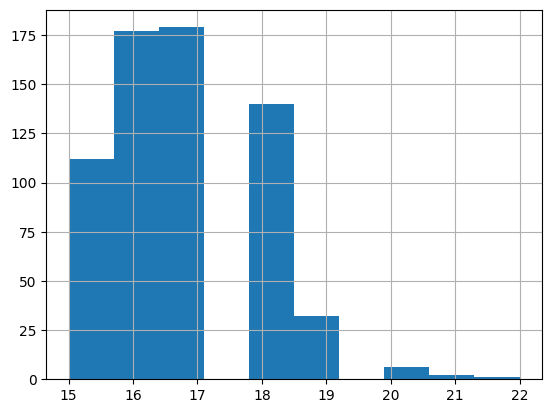

In [10]:
cleaned['age'].hist()

And the distribution ratio

In [21]:
# Eventually, we want to classify all available points. But for now, lets check the disparate impact for students who have passed the year
fin_score_added = cleaned.assign(G3=targ)

under_17 = fin_score_added[fin_score_added['age'] <  17]
num_of_unpriv = under_17.shape[0]
over_17 = fin_score_added[fin_score_added['age'] >= 17]
num_of_priv = over_17.shape[0]

under_17_passed = under_17[under_17['G3'] >= 11].shape[0]
unpriv_ratio = under_17_passed / num_of_unpriv
over_17_passed = over_17[over_17['G3'] >= 11].shape[0]
priv_ratio = over_17_passed / num_of_priv
# Now let's check the disparate impact
age_disp_impact = priv_ratio /unpriv_ratio

print(age_disp_impact)

0.8391025641025642


As we can see, the disparate impact is not too bad, but bias is still present

So, most students are below 17. We will use this as threshold to say that everybody older has more experience and thus may be treated "better"

## Applying the aif360 techniques

In [84]:
# First, instantiate the dataset
ds = StandardDataset(df=cleaned,
                    label_name='age',
                    protected_attribute_names=['age'],
                    favorable_classes=[1],
                    privileged_classes=[lambda x: 1 if x <= 17 else 0],
                    categorical_features=['school_GP', 'school_MS', 'address_R',
                                        'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T',
                                        'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services',
                                        'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other',
                                        'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home',
                                        'reason_other', 'reason_reputation', 'guardian_father',
                                        'guardian_mother', 'guardian_other'],
                    features_to_drop=['sex_F', 'sex_M']
                    )



First, lets try to see the solution of aif360 to detect bias. To do so, we can already use some predicted values

In [23]:
from aif360.detectors.mdss_detector import bias_scan

subset, score = bias_scan(data=cleaned, observations=targ, scoring='Poisson')

In [24]:
import pprint
pprint.pp(subset)
print(f'\n {score}')

{'guardian_father': [False, True],
 'Dalc': [1, 2, 3, 4, 5],
 'age': [15, 16, 17, 18, 19, 20, 21, 22],
 'traveltime': [1, 2, 3, 4],
 'Fjob_teacher': [False, True],
 'activities': [0, 1],
 'absences': [0,
              1,
              2,
              3,
              4,
              5,
              6,
              7,
              8,
              9,
              10,
              11,
              12,
              13,
              14,
              15,
              16,
              18,
              21,
              22,
              24,
              26,
              30,
              32],
 'school_MS': [False, True],
 'Fjob_health': [False, True],
 'sex_M': [False, True],
 'schoolsup': [0, 1],
 'address_R': [False, True],
 'internet': [0, 1],
 'Medu': [0, 1, 2, 3, 4],
 'Fjob_services': [False, True],
 'guardian_other': [False, True],
 'Walc': [1, 2, 3, 4, 5],
 'Fjob_other': [False, True],
 'address_U': [False, True],
 'romantic': [0, 1],
 'paid': [0, 1],
 'school_GP': [Fa

The result is not very meaningful. Looking at the source code, there is something called MDSS. Digging a little deeper, it appears to be called the ***Weighted Multidimensional Scaling Localisation Method***. Essentially, MDSS seems to detect bias by "minimising noise" in a multidimensional data set, essentially detecting where most of the uneven distributions are.

Z. Zhang, D. Wang, B. Yang and J. Yin, "Weighted Multidimensional Scaling Localization Method With Bias Reduction Based on TOA," in IEEE Sensors Journal, vol. 23, no. 17, pp. 19803-19814, 1 Sept.1, 2023, doi: 10.1109/JSEN.2023.3296986. keywords: {Sensors;Location awareness;Estimation;Mathematical models;Noise measurement;Weight measurement;Time measurement;Bias reduction;Cramér–Rao lower bound (CRLB);multidimensional scaling (MDS);sensor-based localization;time-of-arrival (TOA) measurement}, 

Preprocessing

In [85]:
ds_train, ds_test = ds.split([0.8], shuffle=True)
priv_group = [{'age': 1}]
unpriv_group = [{'age': 0}]

In [ ]:
from aif360.algorithms.preprocessing import Reweighing

rew_inst = Reweighing(unprivileged_groups=unpriv_group, privileged_groups=priv_group)
rew_fit = rew_inst.fit(ds)
rew_res = rew_fit.transform(ds)

print(rew_res.convert_to_dataframe()[0]['age'].unique())

And the according results

In [104]:
importlib.reload(ml_methods)

rw_df = rew_res.convert_to_dataframe()[0]

rw_feat_train, rw_feat_test, rw_targ_train, rw_targ_test = sklearn.model_selection.train_test_split(rw_df, targ, test_size=0.2)

rw_ml = ml_methods.MlModelProvider(train_feat=rw_feat_train, train_targ=rw_targ_train)

rw_rf_res = rw_ml.random_forest(already_predict=True, test_feat=rw_feat_test).perceptron(already_predict=True, test_feat=rw_feat_test).return_results()

print(rw_rf_res['random_forest_0']['prediction'])

[14 13 10 11  8  9 13 10 14 10 13 13 12 14 10 13 11 11 14 13 13 10 11 13
 10  0 10 17 13 11 11 10 15 10 13 15 10 10 10 18 10 10 13 13 11 16 11 12
 15 13 13 13  9 11 13 10 17 16 13  9 16 13 11  9 13 10 15 10 14 15 10 13
 12 12 10 13 10 11 12 13 13 16 11 10 13  8 12 13 11 12 10 10 16 17 14 10
  9 13 12 12  9 10 13 11 11 10  8 13 12 11 10 11 11 12 10 11 16 10 11 10
 10 12 11 17 13 10  8 13 11 13]


Confusion matrix after reweighing

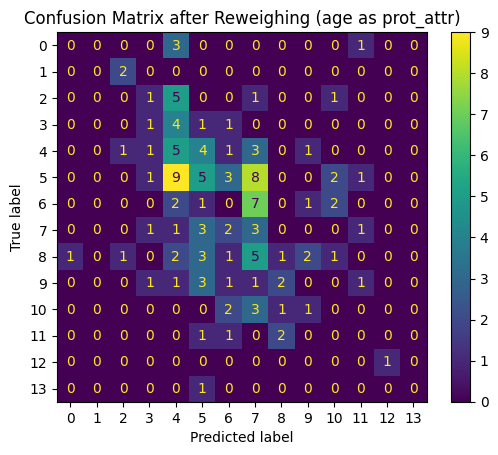

In [144]:
# Confusion matrix
predicted = rw_rf_res['random_forest_0']['prediction']
rw_conf_mtx = sklearn.metrics.confusion_matrix(rw_targ_test, predicted)
init_cf_displ = sklearn.metrics.ConfusionMatrixDisplay(rw_conf_mtx)

rw_perf = {
        'Precision': sklearn.metrics.precision_score(rw_targ_test, predicted, average="weighted", zero_division=True),
        'Accuracy': sklearn.metrics.accuracy_score(rw_targ_test, predicted),
        'F1-Score': sklearn.metrics.f1_score(rw_targ_test, predicted, average="weighted"),
        'Recall': sklearn.metrics.recall_score(rw_targ_test, predicted, average="weighted", zero_division=True)
    }

init_cf_displ.plot()
# plt.text(0, 12, ' '.join([k + str(i) + '\n' for k, i in rw_perf.items()]))
plt.title('Confusion Matrix after Reweighing (age as prot_attr)')
plt.show()

In [113]:
display(Markdown('**Random Forest performance after reweighing**'))
display(Markdown(f'***Accuracy {round(rw_perf["Accuracy"] * 100, 2)} %***'))
display(Markdown(f'***Precision {round(rw_perf["Precision"] * 100, 2)} %***'))
display(Markdown(f'***F1-Score {round(rw_perf["F1-Score"] * 100, 2)} %***'))
display(Markdown(f'***Recall {round(rw_perf["Recall"] * 100, 2)} %***'))

**Random Forest performance after reweighing**

***Accuracy 12.31 %***

***Precision 13.97 %***

***F1-Score 10.88 %***

***Recall 12.31 %***

In [129]:
from aif360.metrics import BinaryLabelDatasetMetric

rw_classf_metr = BinaryLabelDatasetMetric(dataset=rew_res,
                                          unprivileged_groups=unpriv_group,
                                          privileged_groups=priv_group)

rw_aif360_perf = {
"Disparate impact": rw_classf_metr.disparate_impact(),
"Smoothed empricial differential fairness": rw_classf_metr.smoothed_empirical_differential_fairness(),
"Statistical parity": rw_classf_metr.statistical_parity_difference()
}

pprint.pp(rw_aif360_perf)

{'Disparate impact': 0.0,
 'Smoothed empricial differential fairness': 6.507849683389702,
 'Statistical parity': -1.0}


In [132]:
display(Markdown('**Bias Metrics after reweighing**'))
display(Markdown(f'***Disparate impact {rw_aif360_perf["Disparate impact"]}***'))
display(Markdown(f'***Smoothed empricial differential fairness {rw_aif360_perf["Smoothed empricial differential fairness"]}***'))
display(Markdown(f'***Statistical parity {rw_aif360_perf["Statistical parity"]}***'))

**Bias Metrics after reweighing**

***Disparate impact 0.0***

***Smoothed empricial differential fairness 6.507849683389702***

***Statistical parity -1.0***

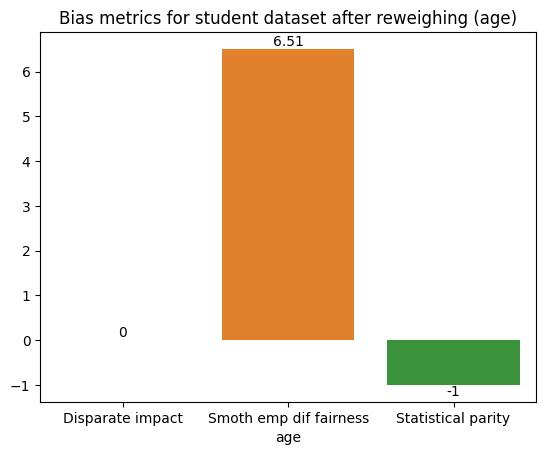

In [166]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt


#Result from the Dalc:
rw_bias_metr_res_dalc = {'Disparate impact': 0.0,
 'Smoothed empricial differential fairness': 5.528328938742544,
 'Statistical parity': -1.0}
rw_heat_df = pd.DataFrame({'Disparate impact': 0.0, 'Smoth emp dif fairness': 6.51, 'Statistical parity': -1.0}, index=[0])

ax = sns.barplot(data=rw_heat_df)
ax.set(xlabel='age')

for i in ax.containers:
    ax.bar_label(i,)

plt.title('Bias metrics for student dataset after reweighing (age)')
plt.show()

## Inprocessing

In [ ]:
importlib.reload(inprocessing)

# Split the dataframes
feat_train, feat_test, targ_train, targ_test = sklearn.model_selection.train_test_split(cleaned, targ, test_size=0.2)
# Split the preprocessed data
rw_train, rw_test = rew_res.split([0.8], shuffle=True)
# Instantiate 
stud_inp_inst = inprocessing.ExecInprocess(dataset=rw_train)
stud_adv_deb = stud_inp_inst.exec_advesarial_debiasing(unpriviledged=unpriv_group,
                                                      priveledged=priv_group,
                                                      predict=True,
                                                      to_predict=rw_test).return_results()  

In [ ]:
importlib.reload(calc_metrics)

stud_adv_deb_df = stud_adv_deb['adveserial_debiasing_0']['predicted'].convert_to_dataframe()[0]
print(stud_adv_deb_df.shape)

adv_deb_feat_train, adv_deb_feat_test, adv_deb_targ_train, adv_deb_targ_test = sklearn.model_selection.train_test_split(stud_adv_deb_df, targ_test, test_size=0.2)

adv_deb = ml_methods.MlModelProvider(train_feat=adv_deb_feat_train, train_targ=adv_deb_targ_train)

adv_deb_res = adv_deb.random_forest(already_predict=True, test_feat=adv_deb_feat_test).perceptron(already_predict=True, test_feat=adv_deb_feat_test).return_results()
# Check the model output
display(Markdown('#### Preprocessing ml Classification results'))
display(Markdown('##### Random Forest'))
adv_deb_rf_metr = calc_metrics.calc_metr(predicted=adv_deb_res['random_forest_0']['prediction'], actual=adv_deb_targ_test)
display(Markdown('\n ##### Perceptron'))
adv_deb_perc_metr = calc_metrics.calc_metr(predicted=adv_deb_res['perceptron_1']['prediction'], actual=adv_deb_targ_test)



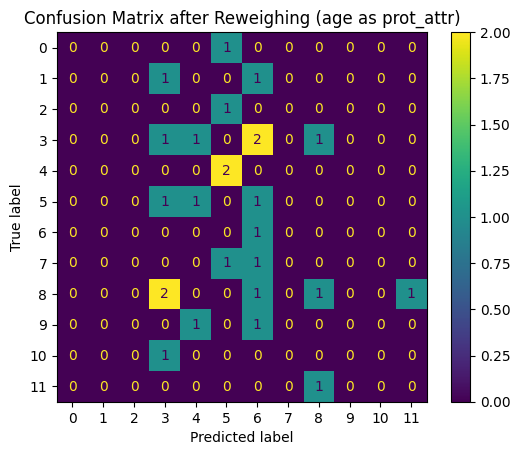

In [176]:
# Confusion matrix
predicted = adv_deb_res['random_forest_0']['prediction']
rw_conf_mtx = sklearn.metrics.confusion_matrix(adv_deb_targ_test, predicted)
init_cf_displ = sklearn.metrics.ConfusionMatrixDisplay(rw_conf_mtx)

adv_deb_perf = {
        'Precision': sklearn.metrics.precision_score(adv_deb_targ_test, predicted, average="weighted", zero_division=True),
        'Accuracy': sklearn.metrics.accuracy_score(adv_deb_targ_test, predicted),
        'F1-Score': sklearn.metrics.f1_score(adv_deb_targ_test, predicted, average="weighted"),
        'Recall': sklearn.metrics.recall_score(adv_deb_targ_test, predicted, average="weighted", zero_division=True)
    }

init_cf_displ.plot()
# plt.text(0, 12, ' '.join([k + str(i) + '\n' for k, i in rw_perf.items()]))
plt.title('Confusion Matrix after Reweighing (age as prot_attr)')
plt.show()

In [178]:
display(Markdown('**Random Forest performance after adversarial debiasing**'))
display(Markdown(f'***Accuracy {round(adv_deb_perf["Accuracy"] * 100, 2)} %***'))
display(Markdown(f'***Precision {round(adv_deb_perf["Precision"] * 100, 2)} %***'))
display(Markdown(f'***F1-Score {round(adv_deb_perf["F1-Score"] * 100, 2)} %***'))
display(Markdown(f'***Recall {round(adv_deb_perf["Recall"] * 100, 2)} %***'))

**Random Forest performance after adversarial debiasing**

***Accuracy 11.54 %***

***Precision 44.71 %***

***F1-Score 9.16 %***

***Recall 11.54 %***

In [ ]:
from aif360.metrics import BinaryLabelDatasetMetric

rw_classf_metr = BinaryLabelDatasetMetric(dataset=stud_adv_deb['adveserial_debiasing_0']['predicted'],
                                          unprivileged_groups=unpriv_group,
                                          privileged_groups=priv_group)

rw_aif360_perf = {
"Disparate impact": rw_classf_metr.disparate_impact(),
"Smoothed empricial differential fairness": rw_classf_metr.smoothed_empirical_differential_fairness(),
"Statistical parity": rw_classf_metr.statistical_parity_difference()
}

pprint.pp(rw_aif360_perf)

In [174]:
display(Markdown('**Bias Metrics after reweighing**'))
display(Markdown(f'***Disparate impact {rw_aif360_perf["Disparate impact"]}***'))
display(Markdown(f'***Smoothed empricial differential fairness {rw_aif360_perf["Smoothed empricial differential fairness"]}***'))
display(Markdown(f'***Statistical parity {rw_aif360_perf["Statistical parity"]}***'))

**Bias Metrics after reweighing**

***Disparate impact inf***

***Smoothed empricial differential fairness 3.7676902813529622***

***Statistical parity 0.25925925925925924***

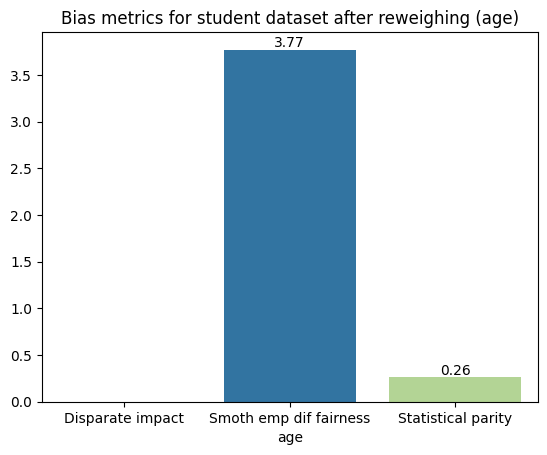

In [182]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt



rw_heat_df = pd.DataFrame({'Disparate impact': np.inf, 'Smoth emp dif fairness': 3.77, 'Statistical parity': 0.26}, index=[0])

ax = sns.barplot(data=rw_heat_df, palette="Paired")
ax.set(xlabel='age')

for i in ax.containers:
    ax.bar_label(i,)

plt.title('Bias metrics for student dataset after reweighing (age)')
plt.show()

Postprocessing

In [ ]:
importlib.reload(postprocessing)

# no_mit_rf_pred_ds = inst_dataset.DatasetInstantiater(train=)

stud_inp_inst = postprocessing.ExecPostprocess(dataset=rw_test)
stud_ceq_odds = stud_inp_inst.exec_cal_equalized_odds(unpriviledged=unpriv_group,
                                                      priveledged=priv_group,
                                                      predicted=stud_adv_deb['adveserial_debiasing_0']['predicted']).return_results()   


print(stud_ceq_odds['eq_odds_0']['fitted'])

In [ ]:
from aif360.algorithms.postprocessing import EqOddsPostprocessing, CalibratedEqOddsPostprocessing

stud_post_inst = CalibratedEqOddsPostprocessing(unprivileged_groups=unpriv_group,
                                                privileged_groups=priv_group)
post_predicted = stud_post_inst.fit_predict(dataset_pred=stud_adv_deb['adveserial_debiasing_0']['predicted'], dataset_true=rw_test)

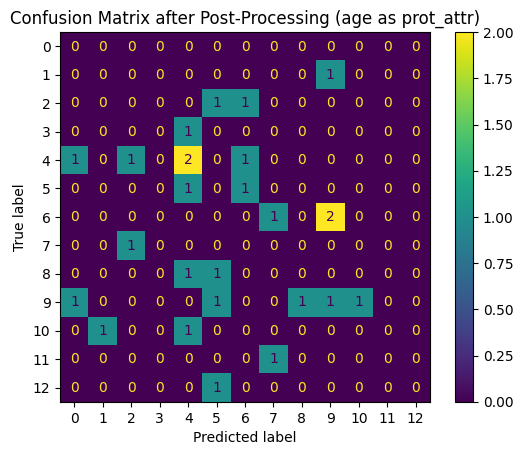

In [213]:
# print(type(post_predicted).convert_to_dataframe()[0])
# Confusion matrix
post_pred_df = post_predicted.convert_to_dataframe()[0]

post_feat_train, post_feat_test, post_targ_train, post_targ_test = sklearn.model_selection.train_test_split(post_pred_df, targ_test, test_size=0.2)


rw_conf_mtx = sklearn.metrics.confusion_matrix(adv_deb_targ_test, post_targ_test)
init_cf_displ = sklearn.metrics.ConfusionMatrixDisplay(rw_conf_mtx)

post_perf = {
        'Precision': sklearn.metrics.precision_score(adv_deb_targ_test, post_targ_test, average="weighted", zero_division=True),
        'Accuracy': sklearn.metrics.accuracy_score(adv_deb_targ_test, post_targ_test),
        'F1-Score': sklearn.metrics.f1_score(adv_deb_targ_test, post_targ_test, average="weighted"),
        'Recall': sklearn.metrics.recall_score(adv_deb_targ_test, post_targ_test, average="weighted", zero_division=True)
    }

init_cf_displ.plot()
# plt.text(0, 12, ' '.join([k + str(i) + '\n' for k, i in rw_perf.items()]))
plt.title('Confusion Matrix after Post-Processing (age as prot_attr)')
plt.show()

In [215]:
display(Markdown('**Random Forest performance after post-processing**'))
display(Markdown(f'***Accuracy {round(post_perf["Accuracy"] * 100, 2)} %***'))
display(Markdown(f'***Precision {round(post_perf["Precision"] * 100, 2)} %***'))
display(Markdown(f'***F1-Score {round(post_perf["F1-Score"] * 100, 2)} %***'))
display(Markdown(f'***Recall {round(post_perf["Recall"] * 100, 2)} %***'))

**Random Forest performance after post-processing**

***Accuracy 11.54 %***

***Precision 22.76 %***

***F1-Score 11.27 %***

***Recall 11.54 %***

In [231]:
from aif360.metrics import BinaryLabelDatasetMetric

post_classf_metr = BinaryLabelDatasetMetric(dataset=post_predicted,
                                          unprivileged_groups=unpriv_group,
                                          privileged_groups=priv_group)

post_aif360_perf = {
"Disparate impact": post_classf_metr.disparate_impact(),
"Smoothed empricial differential fairness": post_classf_metr.smoothed_empirical_differential_fairness(),
"Statistical parity": post_classf_metr.statistical_parity_difference()
}

pprint.pp(post_aif360_perf)

{'Disparate impact': inf,
 'Smoothed empricial differential fairness': 3.7676902813529622,
 'Statistical parity': 0.25925925925925924}


In [226]:
display(Markdown('**Bias Metrics after post-processing**'))
display(Markdown(f'***Disparate impact {post_aif360_perf["Disparate impact"]}***'))
display(Markdown(f'***Smoothed empricial differential fairness {post_aif360_perf["Smoothed empricial differential fairness"]}***'))
display(Markdown(f'***Statistical parity {post_aif360_perf["Statistical parity"]}***'))

**Bias Metrics after post-processing**

***Disparate impact inf***

***Smoothed empricial differential fairness 3.7676902813529622***

***Statistical parity 0.25925925925925924***

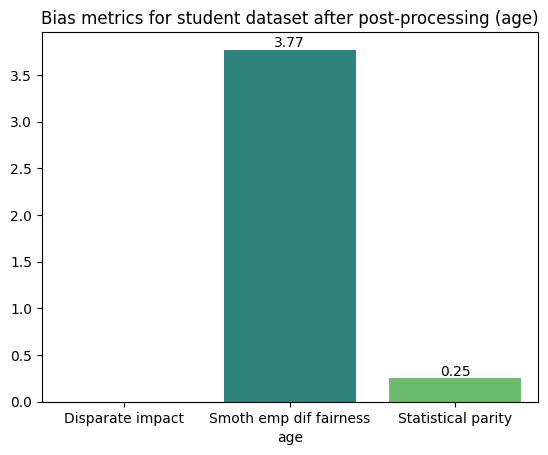

In [235]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt



rw_heat_df = pd.DataFrame({'Disparate impact': np.inf, 'Smoth emp dif fairness': 3.77, 'Statistical parity': 0.25}, index=[0])

ax = sns.barplot(data=rw_heat_df, palette="viridis")
ax.set(xlabel='age')

for i in ax.containers:
    ax.bar_label(i,)

plt.title('Bias metrics for student dataset after post-processing (age)')
plt.show()